### Enunciado
A crime has taken place and the detective needs your help. The detective gave you the crime scene report, but you somehow lost it. You vaguely remember that the crime was a **murder** that occurred sometime on **Jan.15, 2018** and that it took place in **SQL City**. Start by retrieving the corresponding crime scene report from the police department’s database.


### Modelo de datos
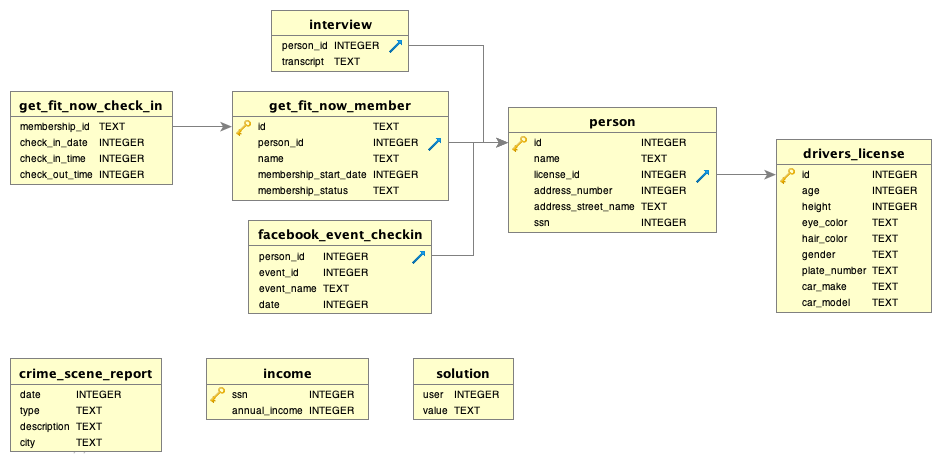




# Solución Noelia

In [2]:
import pandas as pd
import sqlite3 as sq

In [3]:
# Connect to the database
conn = sq.connect('./Data/sql-murder-mystery.db')

# Get a cursor to use for queries
cursor = conn.cursor()

In [4]:
# This function reads the data and passes it to a Pandas DataFrame.
def sql_query(query):

    # Run the query
    cursor.execute(query)

    # Stores query data 
    ans = cursor.fetchall()

    # Gets the names of the columns in the table
    names = [description[0] for description in cursor.description]
    
    return pd.DataFrame(ans, columns = names)

In [5]:
query = '''
SELECT *
FROM crime_scene_report
WHERE (type == "murder") AND (date == 20180115) AND (city = "SQL City")
'''

sql_query(query)

# Complete description: Security footage shows that there were 2 witnesses. The first witness lives at the last house on "Northwestern Dr". The second witness, named Annabel, lives somewhere on "Franklin Ave"

date    type                                        description  \
0  20180115  murder  Security footage shows that there were 2 witne...   

       city  
0  SQL City

In [6]:
query = '''
SELECT
       A.id, A.name, A.address_number, A.address_street_name,
       B.transcript
FROM person AS A
JOIN interview AS B
ON A.id = B.person_id
WHERE (address_street_name LIKE "Northwestern Dr") OR ((name LIKE "Annabel%") AND (address_street_name LIKE "Franklin Ave"))
ORDER BY 3 DESC
'''

df_possible_witnesses = sql_query(query)
df_possible_witnesses

id                  name  address_number address_street_name  \
0   14887        Morty Schapiro            4919     Northwestern Dr   
1   73368        Torie Thalmann            3697     Northwestern Dr   
2   96595         Coretta Cubie            3631     Northwestern Dr   
3   28360        Rashad Cascone            3212     Northwestern Dr   
4   51114     Christena Saffell            3055     Northwestern Dr   
5   68690            Yer Modest            3046     Northwestern Dr   
6   34352    Vincenza Burkhardt            2512     Northwestern Dr   
7   80921       Donovan Yackley            2386     Northwestern Dr   
8   88423           Teri Ehrich            1879     Northwestern Dr   
9   72076     Courtney Bordeaux            1707     Northwestern Dr   
10  71924        Laurie Scronce            1418     Northwestern Dr   
11  23960  Kristopher Lagerberg            1392     Northwestern Dr   
12  25615         Olevia Morena             812     Northwestern Dr   
13  39688            Abe Roeker             689     Northwestern Dr   
14  26758      Angelena Billman             629     Northwestern Dr   
15  75484          Del Tacderen             607     Northwestern Dr   
16  12711        Norman Apolito             599     Northwestern Dr   
17  85280             Donn Duin             540     Northwestern Dr   
18  40336       Fredia Billeter             404     Northwestern Dr   
19  15171          Weldon Penso             311     Northwestern Dr   
20  16371        Annabel Miller             103        Franklin Ave   

                                           transcript  
0   I heard a gunshot and then saw a man run out. ...  
1   doesn’t suit my throat!’ and a Canary called o...  
2   head in the lap of her sister, who was gently ...  
3                          for apples, yer honour!’\n  
4        ‘So you did, old fellow!’ said the others.\n  
5                                                  \n  
6   Poor Alice! It was as much as she could do, ly...  
7                                                  \n  
8   sea, some children digging in the sand with wo...  
9   see: four times five is twelve, and four times...  
10  interrupted: ‘UNimportant, your Majesty means,...  
11  This was quite a new idea to Alice, and she th...  
12                             when I learn music.’\n  
13  ‘Hold your tongue!’ said the Queen, turning pu...  
14   Will you, won’t you, will you, won’t you, won...  
15  ‘We had the best of educations--in fact, we we...  
16                                                 \n  
17                                          verse.’\n  
18  stretched her arms round it as far as they wou...  
19  the verses to himself: ‘“WE KNOW IT TO BE TRUE...  
20  I saw the murder happen, and I recognized the ...

#### WITNESSES

|id|name|address_number|address_street_name|transcript|
|----------|----------|----------|----------|----------|
|14887|Morty Schapiro|4919|Northwestern Dr|I heard a gunshot and then saw a man run out. He had a "Get Fit Now Gym" bag. The membership number on the bag started with "48Z". Only gold members have those bags. The man got into a car with a plate that included "H42W".|
|16371|Annabel Miller|103|Franklin Ave|I saw the murder happen, and I recognized the killer from my gym when I was working out last week on January the 9th.|

In [7]:
# Keep the 2 witnesses

query = '''
SELECT
       A.name, A.id,
       B.transcript
FROM person AS A
JOIN interview AS B
ON A.id = B.person_id
WHERE (A.id = 14887)OR (A.id = 16371)
'''

df_witnesses = sql_query(query)
df_witnesses

name     id                                         transcript
0  Morty Schapiro  14887  I heard a gunshot and then saw a man run out. ...
1  Annabel Miller  16371  I saw the murder happen, and I recognized the ...

In [8]:
# Following the clues from witness statements:

query = '''
SELECT 
        A.id, A.name, A.license_id,
        B.plate_number,
        C.person_id,
        D.check_in_date,
        E.transcript
        
FROM person AS A
JOIN drivers_license AS B ON A.license_id = B.id
JOIN get_fit_now_member AS C ON A.id = C.person_id
JOIN get_fit_now_check_in AS D ON C.id = D.membership_id
JOIN interview AS E ON A.id = E.person_id

WHERE (D.check_in_date = 20180109)
AND (D.membership_id LIKE "48Z%")
AND (C.membership_status = "gold")
AND (B.plate_number LIKE "%H42W%")
'''

sql_query(query)

id           name  license_id plate_number  person_id  check_in_date  \
0  67318  Jeremy Bowers      423327       0H42W2      67318       20180109   

                                          transcript  
0  I was hired by a woman with a lot of money. I ...

In [9]:
# I was hired by a woman with a lot of money. I don't know her name but I
# know she's around 5'5" (65") or 5'7" (67"). She has red hair and she drives
# a Tesla Model S. I know that she attended the SQL Symphony Concert 3 times
# in December 2017.

# According to his statements, although he was the killer,
# he was working for someone... ¿for whom?

query = '''
SELECT 
        A.id, A.name,
        B.height, B.hair_color, B.car_make, B.car_model, 
        C.person_id, C.event_name, C.date,
        D.transcript

FROM person AS A
JOIN drivers_license AS B ON A.license_id = B.id
JOIN facebook_event_checkin AS C ON A.id = C.person_id
JOIN interview AS D ON A.id = D.person_id

WHERE (B.gender = "female")
AND (B.height BETWEEN 65 AND 67)
AND (B.hair_color = "red")
AND (B.car_make = "Tesla")
AND (B.car_model = "Model S")
AND (C.event_name = "SQL Symphony Concert")
AND (C.date BETWEEN 20171201 AND 20171231)
'''
sql_query(query)

Empty DataFrame
Columns: [id, name, height, hair_color, car_make, car_model, person_id, event_name, date, transcript]
Index: []

In [10]:
query = '''
SELECT A.id, A.car_make, A.car_model
FROM drivers_license AS A
'''

df = sql_query(query)
print('Tesla' in df['car_make'])
print('Model S' in df['car_model'])

False
False
